# Motivations
* Whether our model could update FE such that the updated weights could predict similar activation map as in pretrained VGG19?

In [18]:
import torch
from models.new_model import FeatureExtractor
from torch.utils.data.dataloader import DataLoader
from dataset import dataloader
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(0)
FE = FeatureExtractor()

/home/qiwang/anaconda3/envs/ven/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/qiwang/anaconda3/envs/ven/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [20]:
def load_unmatched(model, pretrain_path, key_dict:str='state_dict'):
    pretrains = torch.load(pretrain_path)
    net_dict = model.state_dict()
    pretrain_dict = {k.replace("module.",""): v for k, v in pretrains["%s"%key_dict].items() if k.replace("module.","") in net_dict.keys()}
    net_dict.update(pretrain_dict)
    model.load_state_dict(net_dict)
    return model

In [26]:
norm = lambda x : (x-x.mean())/x.std()

In [50]:
def plot_grids(sr_tensor:torch.Tensor, name:str, normalize:bool=True)-> None:
    grids = make_grid(sr_tensor)
    if normalize:
        grids = norm(grids)
    plt.figure(figsize=(10,20))
    plt.imshow(grids[0].detach().cpu().numpy(),vmin=0)
    plt.title(name)
    plt.axis('off')
    

In [21]:
%%capture --no-display
# load our weights to VGG-19
FE = FeatureExtractor().cuda()
#ckp = torch.load("esrgan_2d_FE_9_epoch.pth")
#FE.load_state_dict(ckp['FE_state_dict'])
load_unmatched(FE, "esrgan_2d_FE_9_epoch.pth", key_dict = "FE_state_dict")

FeatureExtractor(
  (vgg19_54): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride

### Get random batch of image

In [3]:
dst = dataloader(root='/big_data/qi1/Celeba/train', hr_shape=64)
img = DataLoader(dst, batch_size=16,shuffle=True,)

In [23]:
_,im = next(enumerate(img))
print(im['hr'].shape)

torch.Size([16, 3, 64, 64])


In [24]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

### Activation maps

In [16]:
from torchvision.models import vgg19

### Pretrained FE

In [17]:
VGG19 = vgg19(weights='DEFAULT')
VGG19 = VGG19.cuda()
ls_vgg19 = list(VGG19.named_modules())
res_VGG19 = VGG19.features[0](im['hr'].cuda())

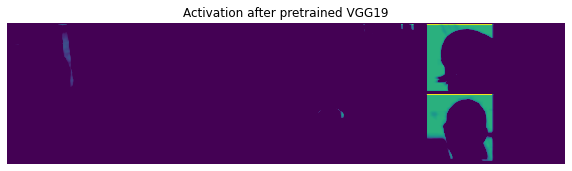

In [51]:
plot_grids(res_VGG19,'Activation after pretrained VGG19')

In [34]:
grid_pre, grid_act, grid_empty = map(norm,[grid_pre, grid_act, grid_empty])
[print("max:%.3f\tmin:%.3f\tmean:%.3f"%(x.max(), x.min(), x.mean())) for x in [grid_pre, grid_act, grid_empty]]

max:11.317	min:-9.850	mean:-0.000
max:4.346	min:-4.105	mean:0.000
max:4.663	min:-4.516	mean:0.000


[None, None, None]

### Our frozen FE

In [28]:
# infer image through FE with our trained weights
ls = list(FE.vgg19_54.named_modules())
first_conv_kernel = ls[0][1][0]
print(first_conv_kernel)

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [29]:
SR = first_conv_kernel(im['hr'].cuda())

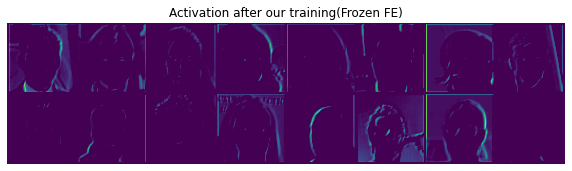

In [52]:
plot_grids(SR, "Activation after our training(Frozen FE)")

### Random weight FE

In [53]:
# infer image through empty weights of FE
FE_empty = FeatureExtractor().cuda()
ls_empty = list(FE_empty.vgg19_54.named_modules())
first_conv_FE = ls_empty[0][1][0]
res_empty = first_conv_FE(im['hr'].cuda())

/home/qiwang/anaconda3/envs/ven/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/qiwang/anaconda3/envs/ven/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


applied Linear!
applied Linear!
applied Linear!
applied Linear!
applied Linear!
applied Linear!
applied Linear!
applied Linear!
applied Linear!
applied Linear!
applied Linear!
applied Linear!
applied Linear!
applied Linear!
applied Linear!
applied Linear!


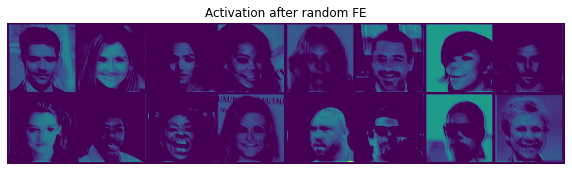

In [55]:
plot_grids(res_empty, "Activation after random FE")

### Tried to visualize Kernels, while not distinguishible

In [65]:
ls_param = list(FE.parameters())
grid = make_grid(ls_param[0])

In [66]:
ls_param_empty = list(FE_empty.parameters())
grid_kernel_empty = make_grid(ls_param_empty[0])

## Empirical spectral density(ESD) --- the eigenvalues of layers

In [132]:
# weights of first Conv1
list(VGG19.features.parameters())[0].shape

torch.Size([64, 3, 3, 3])

In [133]:
weights_pre = list(VGG19.features.parameters())[0]

In [134]:
weights_empty = list(FE_empty.parameters())[0]

In [178]:
weights_ours = list(FE.parameters())[0]

In [136]:
eigv_pre = torch.linalg.eigvals(weights_pre)

In [137]:
eigv_empty = torch.linalg.eigvals(weights_empty)

In [179]:
eigv_ours = torch.linalg.eigvals(weights_ours)

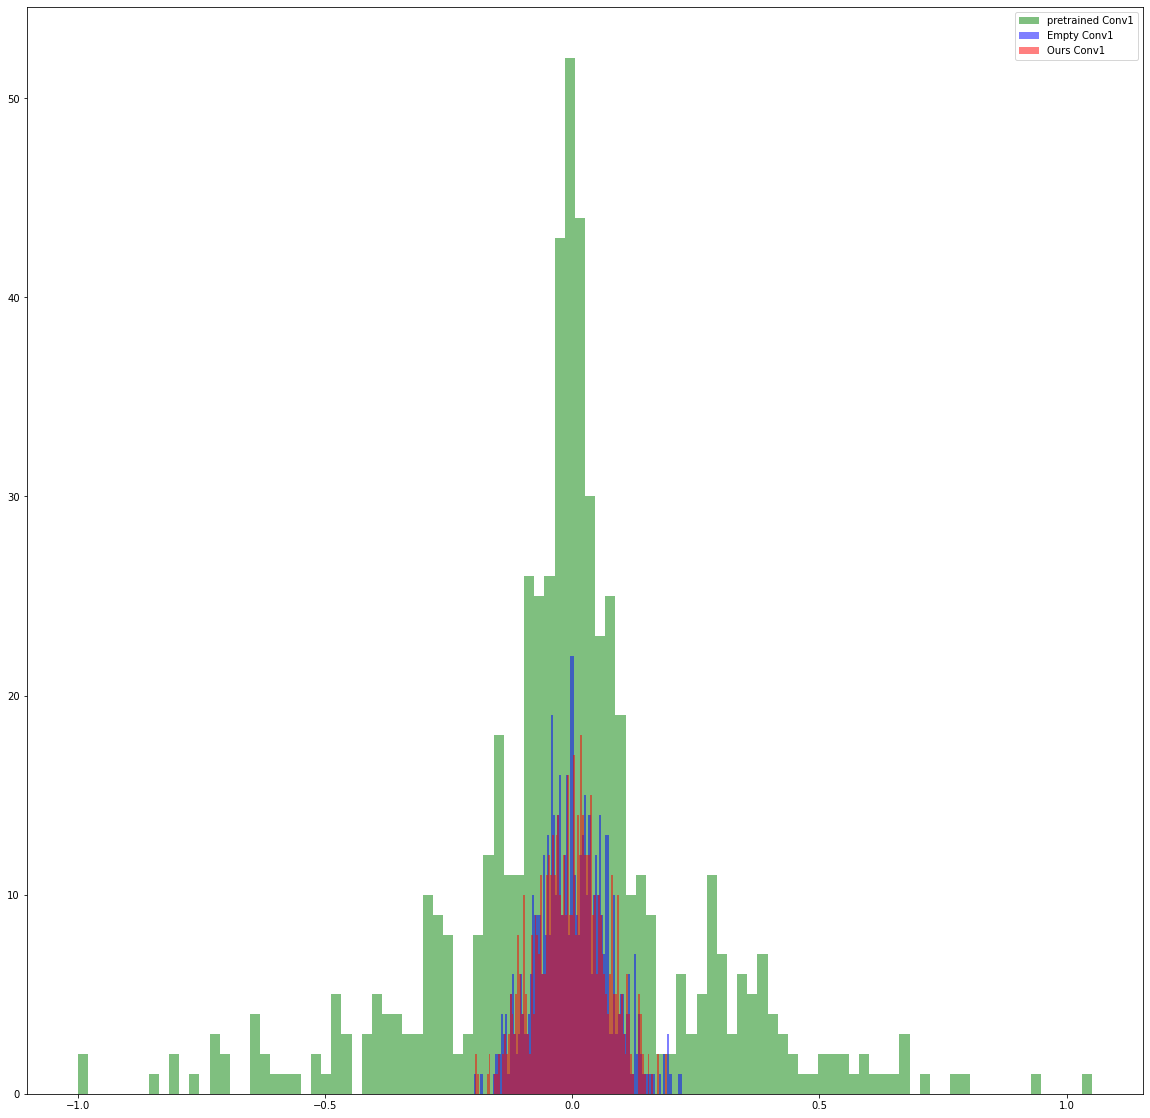

In [181]:
plt.figure(figsize=(20,20))
plt.hist(eigv_pre.real.detach().flatten().cpu().numpy(),bins=100,color='green',alpha=0.5,label='pretrained Conv1')
plt.hist(eigv_empty.real.detach().flatten().cpu().numpy(),bins=100,color='blue',alpha=0.5,label='Empty Conv1')
plt.hist(eigv_ours.real.detach().flatten().cpu().numpy(),bins=100,color='red',alpha=0.5,label='Ours Conv1')
plt.legend()